In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split


In [2]:
def load_data(file_path):
    # Load data from the given file path
    data = pd.read_csv(file_path)
    return data

In [3]:
from imblearn.over_sampling import SMOTENC
from collections import Counter
import pandas as pd
def preprocess_data(data):
    df = data.copy()
    # Rename features
    df.rename(mapper={'Air temperature [K]': 'Air temperature',
                      'Process temperature [K]': 'Process temperature',
                      'Rotational speed [rpm]': 'Rotational speed',
                      'Torque [Nm]': 'Torque',
                      'Tool wear [min]': 'Tool wear'}, axis=1, inplace=True)
    # Set numeric columns dtype to float
    df['Tool wear'] = df['Tool wear'].astype('float64')
    df['Rotational speed'] = df['Rotational speed'].astype('float64')

    # Drop the first two columns
    df = df.iloc[:, 2:]
    
    # Remove entries where 'Failure' is 1 but 'Failure Type' is 'No Failure'
    df = df[(df['Target'] != 1) | (df['Failure Type'] != 'No Failure')]

    # Reset index of the DataFrame
    df.reset_index(drop=True, inplace=True)

    # Separate features and target variable
#     X = df.drop(columns=['Failure Type'])
#     y = data['Failure Type']
    
    # Define the desired length of the resampled dataframe
    n_working = df['Failure Type'].value_counts()['No Failure']
    desired_length = round(n_working / 0.8)
    spc = round((desired_length - n_working) / 4)  # samples per class
    
    # Define the sampling strategy for SMOTENC
    balance_cause = {
        'No Failure': n_working,
        'Overstrain Failure': spc,
        'Heat Dissipation Failure': spc,
        'Power Failure': spc,
        'Tool Wear Failure': spc
    }
    
    # Specify the indices of categorical features
    categorical_features_indices = [0, 7]  # Example indices, please replace with your actual categorical feature indices
    
    # Perform SMOTENC resampling
    sm = SMOTENC(categorical_features=categorical_features_indices, sampling_strategy=balance_cause, random_state=0)
    df_res, y_res = sm.fit_resample(df, df['Failure Type'])
    
    
    # Combine resampled features and target variable into a DataFrame
#     resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
#     resampled_df['Failure Type'] = y_resampled
    
    # Return the resampled DataFrame
    return df_res,y_res

In [4]:
def split_data(data):
    # Split data into train, validation, and test sets
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    validation_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

    return train_data, validation_data, test_data

In [5]:
def store_splits(train_data, validation_data, test_data):
    # Convert the data to pandas DataFrame
    train_df = pd.DataFrame(train_data)
    validation_df = pd.DataFrame(validation_data)
    test_df = pd.DataFrame(test_data)

    # Store the splits as CSV files
    train_df.to_csv('train.csv', index=False)
    validation_df.to_csv('validation.csv', index=False)
    test_df.to_csv('test.csv', index=False)

In [6]:
file_path = r'/kaggle/input/machine-predictive-maintenance-classification/predictive_maintenance.csv'
data = load_data(file_path)

In [7]:
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [8]:
# Create lists of features and target names
features = [col for col in data.columns
            if data[col].dtype=='float64' or col =='Type']
target = ['Target','Failure Type']
# Portion of data where RNF=1
idx_RNF = data.loc[data['Failure Type']=='Random Failures'].index
data.loc[idx_RNF,target]

,Target,Failure Type
1221,0,Random Failures
1302,0,Random Failures
1748,0,Random Failures
2072,0,Random Failures
2559,0,Random Failures
3065,0,Random Failures
3452,0,Random Failures
5471,0,Random Failures
5489,0,Random Failures
5495,0,Random Failures


In [9]:
first_drop = data.loc[idx_RNF,target].shape[0]
print('Number of observations where RNF=1 but Machine failure=0:',first_drop)
# Drop corresponding observations and RNF column
data.drop(index=idx_RNF, inplace=True)

Number of observations where RNF=1 but Machine failure=0: 18


In [10]:
df_res,y_res = preprocess_data(data)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

Failures percentage in data: 3.4


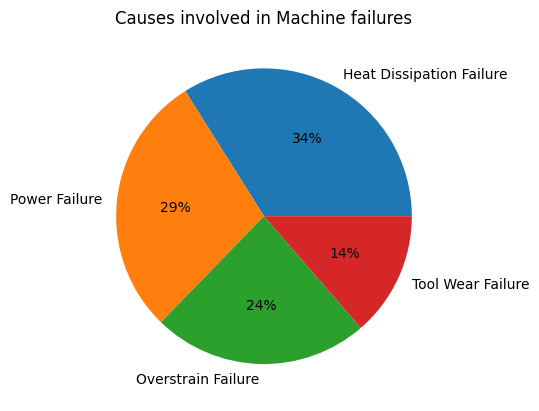

In [12]:
import seaborn as sns
n = data.shape[0]
# Portion of df where there is a failure and causes percentage
idx_fail = data.loc[data['Failure Type'] != 'No Failure'].index
df_fail = data.loc[idx_fail]
df_fail_percentage = 100*df_fail['Failure Type'].value_counts()/df_fail['Failure Type'].shape[0]
print('Failures percentage in data:',
      round(100*data['Target'].sum()/n,2))
# Pie plot
plt.title('Causes involved in Machine failures')
plt.pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
plt.show()

Percentage increment of observations after oversampling: 20.77
SMOTE Resampled Failures percentage: 20.01


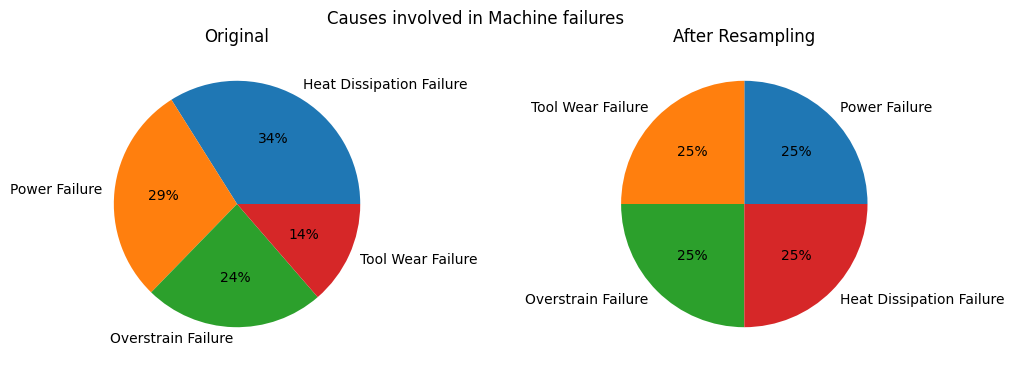

In [13]:
import matplotlib.pyplot as plt
# Portion of df_res where there is a failure and causes percentage
idx_fail_res = df_res.loc[df_res['Failure Type'] != 'No Failure'].index
df_res_fail = df_res.loc[idx_fail_res]
fail_res_percentage = 100*df_res_fail['Failure Type'].value_counts()/df_res_fail.shape[0]

# Percentages
print('Percentage increment of observations after oversampling:',
      round((df_res.shape[0]-data.shape[0])*100/data.shape[0],2))
print('SMOTE Resampled Failures percentage:',
      round(df_res_fail.shape[0]*100/df_res.shape[0],2))

# Pie plot
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
fig.suptitle('Causes involved in Machine failures')
axs[0].pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[1].pie(x=fail_res_percentage.array, labels=fail_res_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[0].title.set_text('Original')
axs[1].title.set_text('After Resampling')
plt.show()

In [14]:

train_data, validation_data, test_data = split_data(df_res)
store_splits(train_data, validation_data, test_data)